# Installing FinRL

In [ ]:
## install finrl library
%pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-vaymlkl8
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-vaymlkl8
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5geh3nz9/pyfolio_1a413da7a2c148918974ed2cdab0ad73
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5geh3nz9/pyfolio_1a413da7a2c148918974ed2cdab0ad73
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5geh3nz9/elegantrl_b4e3f18c8381491399f18bbb569a69b4
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5geh3nz9/elegantrl_b4e3f18c8381491399f18bbb569a69b4


# Making required directories

In [ ]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
#from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading stock prices

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/stocks_dataset/stock_prices.csv')

df_2 = df.loc[df['SecuritiesCode'].isin([1301, 1332, 1333, 1376, 1377, 1379, 1381, 1407, 1414, 1417])] # Security codes represents stock name

In [ ]:
df_2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2330537,20211203_1379,2021-12-03,1379,1870.0,1893.0,1870.0,1891.0,27400,1.0,NaN,False,0.019058
2330538,20211203_1381,2021-12-03,1381,3125.0,3200.0,3125.0,3200.0,700,1.0,NaN,False,0.004762
2330539,20211203_1407,2021-12-03,1407,6030.0,6200.0,5900.0,6190.0,355900,1.0,NaN,False,0.019293
2330541,20211203_1414,2021-12-03,1414,4990.0,5100.0,4965.0,5100.0,198100,1.0,NaN,False,0.015810


# Extracting the required columns for Feature Engineering

In [ ]:
df_c = df_2[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SecuritiesCode']]
df_c

df_c.to_csv('export_dataframe.csv', index = None, header=True) 

In [ ]:
result = df_c.dtypes
result

Date               object
Open              float64
High              float64
Low               float64
Close             float64
Volume              int64
SecuritiesCode      int64
dtype: object

# Exporing the extracted columns to new csv

In [ ]:
df_3 = pd.read_csv('export_dataframe.csv')
df_3

,Date,Open,High,Low,Close,Volume,SecuritiesCode
0,2017-01-04,2734.0,2755.0,2730.0,2742.0,31400,1301
1,2017-01-04,568.0,576.0,563.0,571.0,2798500,1332
2,2017-01-04,3150.0,3210.0,3140.0,3210.0,270800,1333
3,2017-01-04,1510.0,1550.0,1510.0,1550.0,11300,1376
4,2017-01-04,3270.0,3350.0,3270.0,3330.0,150800,1377
...,...,...,...,...,...,...,...
12015,2021-12-03,1870.0,1893.0,1870.0,1891.0,27400,1379
12016,2021-12-03,3125.0,3200.0,3125.0,3200.0,700,1381
12017,2021-12-03,6030.0,6200.0,5900.0,6190.0,355900,1407
12018,2021-12-03,4990.0,5100.0,4965.0,5100.0,198100,1414


# Converting the Securities Code from int64 to string object

In [ ]:
df_3['SecuritiesCode'] = df_3['SecuritiesCode'].apply(str)

In [ ]:
df_3.sort_values(['Date','SecuritiesCode'],ignore_index=True).tail(200)

,Date,Open,High,Low,Close,Volume,SecuritiesCode
11820,2021-11-05,3150.0,3160.0,3105.0,3110.0,18900,1301
11821,2021-11-05,637.0,670.0,624.0,661.0,6031200,1332
11822,2021-11-05,2580.0,2605.0,2570.0,2603.0,101400,1333
11823,2021-11-05,1516.0,1516.0,1495.0,1500.0,3700,1376
11824,2021-11-05,3420.0,3435.0,3420.0,3420.0,42900,1377
...,...,...,...,...,...,...,...
12015,2021-12-03,1870.0,1893.0,1870.0,1891.0,27400,1379
12016,2021-12-03,3125.0,3200.0,3125.0,3200.0,700,1381
12017,2021-12-03,6030.0,6200.0,5900.0,6190.0,355900,1407
12018,2021-12-03,4990.0,5100.0,4965.0,5100.0,198100,1414


In [ ]:
result_4 = df_3.dtypes
result_4

Date               object
Open              float64
High              float64
Low               float64
Close             float64
Volume              int64
SecuritiesCode     object
dtype: object

# Renaming the column names because it is required by Feature Engineering

In [ ]:
df_3.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume', 'SecuritiesCode':'tic'}, inplace = True)
df_3

# Preprocessing
## Applying Feature Engineering on the dataset

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df_3)

In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

# Splitting the data

In [ ]:
train = data_split(processed_full, '2017-01-04','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

7416
2853


In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
823,2020-06-30,1377,3460.0,3480.0,3430.0,3440.0,102800.0,-36.593728,3647.009919,3321.990081,48.567700,-61.875671,2.520241,3533.166667,3507.250000,30.43,4.30489
823,2020-06-30,1379,2039.0,2043.0,2023.0,2030.0,66900.0,13.646587,2053.369565,1962.530435,56.081788,124.826036,3.329848,2006.766667,1971.700000,30.43,4.30489
823,2020-06-30,1407,2238.0,2261.0,2146.0,2184.0,159700.0,115.076965,2381.537601,1616.162399,62.467613,113.615743,35.344671,1964.666667,1774.966667,30.43,4.30489
823,2020-06-30,1414,4880.0,4880.0,4765.0,4775.0,136600.0,25.295398,5061.692039,4743.307961,53.330967,-59.574468,4.371023,4881.166667,4607.083333,30.43,4.30489
823,2020-06-30,1417,1640.0,1656.0,1608.0,1608.0,266000.0,33.475646,1652.719311,1465.080689,58.307774,137.227631,25.152770,1544.333333,1450.883333,30.43,4.30489


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,1301,2716.0,2732.0,2673.0,2680.0,22600.0,5.263214,2788.994065,2638.605935,50.170543,-45.346498,8.804069,2710.466667,2642.683333,28.620001,13.020932
0,2020-07-01,1332,471.0,471.0,457.0,461.0,1853200.0,-6.506016,527.137010,450.462990,45.010734,-133.964248,29.873136,490.800000,478.183333,28.620001,13.020932
0,2020-07-01,1333,2195.0,2201.0,2161.0,2162.0,157300.0,-28.863883,2406.874113,2076.825887,45.081492,-84.222642,18.464684,2257.300000,2259.166667,28.620001,13.020932
0,2020-07-01,1376,1492.0,1500.0,1472.0,1486.0,22700.0,3.269222,1507.906031,1393.993969,54.778817,71.315748,9.870881,1455.066667,1456.516667,28.620001,13.020932
0,2020-07-01,1377,3430.0,3430.0,3300.0,3315.0,142400.0,-44.658664,3630.285571,3306.214429,43.852475,-127.651747,25.061859,3521.333333,3511.166667,28.620001,13.020932


In [ ]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

# Defining the Environment

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 9, State Space: 91


In [ ]:
#num_stock_shares = [0] * stock_dimension from https://github.com/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb

env_kwargs = {
    "hmax": 100, 
    # initial_amount = 1000000, and hold no shares at beginning.
    #"initial_list": [1000000] + [0 for i in range(stock_dimension)],
    "initial_amount": 130000000, # In YEN
    "num_stock_shares": [0] * stock_dimension,
    # buy and sell cost for each stock
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Training environment

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
agent = DRLAgent(env = env_train)

# Trading
### Assume that we have 130m Yen initial capital at 2020-07-01

## Setting turbulence threshold
### Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

count    824.000000
mean      16.976456
std        9.719649
min        9.190000
25%       11.732500
50%       13.740000
75%       18.030000
max       82.690002
Name: vix, dtype: float64

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

74.4567608642577

In [ ]:
insample_risk_indicator.turbulence.describe()

count     824.000000
mean        9.322270
std        48.166223
min         0.000000
25%         0.000000
50%         4.561011
75%         9.465536
max      1343.527661
Name: turbulence, dtype: float64

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

95.2501502293631

# Trade

### DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

### Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,1301,2716.0,2732.0,2673.0,2680.0,22600.0,5.263214,2788.994065,2638.605935,50.170543,-45.346498,8.804069,2710.466667,2642.683333,28.620001,13.020932
0,2020-07-01,1332,471.0,471.0,457.0,461.0,1853200.0,-6.506016,527.137010,450.462990,45.010734,-133.964248,29.873136,490.800000,478.183333,28.620001,13.020932
0,2020-07-01,1333,2195.0,2201.0,2161.0,2162.0,157300.0,-28.863883,2406.874113,2076.825887,45.081492,-84.222642,18.464684,2257.300000,2259.166667,28.620001,13.020932
0,2020-07-01,1376,1492.0,1500.0,1472.0,1486.0,22700.0,3.269222,1507.906031,1393.993969,54.778817,71.315748,9.870881,1455.066667,1456.516667,28.620001,13.020932
0,2020-07-01,1377,3430.0,3430.0,3300.0,3315.0,142400.0,-44.658664,3630.285571,3306.214429,43.852475,-127.651747,25.061859,3521.333333,3511.166667,28.620001,13.020932


In [ ]:
import random
from tqdm.notebook import tqdm

SEEDS = [11, 22, 33]

%matplotlib inline

# Calling different Deep RL algorithms
## A2C

In [ ]:
df_account_value_a2c_arr, df_actions_a2c_arr = [], []

for seed in tqdm(SEEDS, desc='All seeds', leave=True): # Looping from the given seeds

  # Train
  random.seed(seed); np.random.seed(seed) ; env_train.seed(seed)
  agent = DRLAgent(env = env_train)
  model_a2c = agent.get_model("a2c")
  trained_a2c = agent.train_model(model=model_a2c, 
                              tb_log_name='a2c',
                              total_timesteps=50000)

  trained_a2c.save('trained_a2c.model') # save the model

  # Prediction
  df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)
  df_account_value_a2c.shape
  df_account_value_a2c.tail()
  df_actions_a2c.head()
  df_account_value_a2c_arr.append(df_account_value_a2c)
  df_actions_a2c_arr.append(df_actions_a2c)

All seeds:   0%|          | 0/3 [00:00<?, ?it/s]

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 191      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -12.7    |
|    explained_variance | -0.0123  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 4.27e+03 |
|    reward             | 289.9015 |
|    std                | 0.99     |
|    value_loss         | 1.06e+05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 195      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -12.7    |
|    explained_variance | 5.96e-08 |

# A2C for trading

In [ ]:
df_account_value_a2c_con = pd.concat((df_account_value_a2c_arr))
df_actions_a2c_con = pd.concat((df_actions_a2c_arr))

df_account_value_a2c_con_idx = df_account_value_a2c_con.groupby(df_account_value_a2c_con.index)
df_actions_a2c_con_idx = df_actions_a2c_con.groupby(df_actions_a2c_con.index)

df_account_value_means_a2c = df_account_value_a2c_con_idx.mean()
df_actions_means_a2c = df_actions_a2c_con_idx.mean()

In [ ]:
df_account_value_means_a2c['date'] = df_account_value_a2c_arr[0]['date']
df_account_value_means_a2c = df_account_value_means_a2c[['date', 'account_value']]
df_account_value_means_a2c.tail()

,date,account_value
312,2021-10-25,1.408302e+08
313,2021-10-26,1.416708e+08
314,2021-10-27,1.414718e+08
315,2021-10-28,1.422813e+08
316,2021-10-29,1.428322e+08


In [ ]:
df_actions_means_a2c

,1301,1332,1333,1376,1377,1379,1407,1414,1417
date,,,,,,,,,
2020-07-01,78.333333,75.666667,94.333333,66.666667,33.333333,66.666667,19.666667,33.333333,33.333333
2020-07-02,78.333333,75.666667,94.333333,66.666667,33.333333,66.666667,19.666667,33.333333,33.333333
2020-07-06,78.333333,75.666667,94.333333,66.666667,33.333333,66.666667,19.666667,33.333333,33.333333
2020-07-07,78.333333,75.666667,94.333333,66.666667,33.333333,66.666667,19.666667,33.333333,33.333333
2020-07-08,78.333333,75.666667,94.333333,66.666667,33.333333,66.666667,19.666667,33.333333,33.333333
...,...,...,...,...,...,...,...,...,...
2021-10-22,45.000000,42.333333,66.666667,33.333333,33.333333,33.333333,19.666667,34.666667,-36.666667
2021-10-25,11.666667,33.333333,33.333333,0.000000,0.000000,0.000000,0.000000,6.333333,-3.333333
2021-10-26,-21.666667,27.333333,0.000000,-33.333333,-33.333333,-33.333333,-24.333333,-32.000000,30.000000


## BackTestStats

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_a2c = backtest_stats(account_value=df_account_value_means_a2c)
perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.077705
Cumulative returns     0.098709
Annual volatility      0.226633
Sharpe ratio           0.443713
Calmar ratio           0.494519
Stability              0.567642
Max drawdown          -0.157132
Omega ratio            1.148725
Sortino ratio          0.667177
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.073617
Daily value at risk   -0.028154
dtype: float64


In [ ]:
df_date_a2c = df_account_value_means_a2c.set_index("date")

In [ ]:
df_date_a2c.index = pd.to_datetime(df_date_a2c.index)

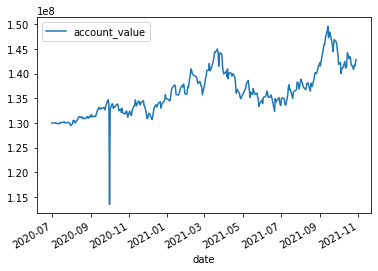

In [ ]:
df_date_a2c.plot()

In [ ]:
df_date_a2c.to_csv("a2c_account_value.csv.gz")

In [ ]:
del df_account_value_a2c_arr ; del df_actions_a2c_arr

## DDPG

In [ ]:
env_train.reset()
df_account_value_ddpg_arr, df_actions_ddpg_arr = [], []

for seed in tqdm(SEEDS, desc='All seeds', leave=True): # Looping from the given seeds

  # Train
  random.seed(seed); np.random.seed(seed) ; env_train.seed(seed)
  agent = DRLAgent(env = env_train)
  model_ddpg = agent.get_model("ddpg")
  trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

  trained_ddpg.save('trained_ddpg.model') # save the model

  # Prediction
  df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)
  df_account_value_ddpg.shape
  df_account_value_ddpg.tail()
  df_actions_ddpg.head()
  df_account_value_ddpg_arr.append(df_account_value_ddpg)
  df_actions_ddpg_arr.append(df_actions_ddpg)

All seeds:   0%|          | 0/3 [00:00<?, ?it/s]

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 93         |
|    time_elapsed    | 35         |
|    total_timesteps | 3296       |
| train/             |            |
|    actor_loss      | 1.83e+05   |
|    critic_loss     | 3.6e+07    |
|    learning_rate   | 0.001      |
|    n_updates       | 2472       |
|    reward          | -25.454384 |
-----------------------------------
day: 823, episode: 190
begin_total_asset: 130000000.00
end_total_asset: 137335870.68
total_reward: 7335870.68
total_cost: 186380.62
total_trades: 4293
Sharpe: 0.204
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 82         |
|    time_elapsed    | 79         |
|    total_timesteps | 6592       |
| train/             |            |
|    actor_loss      | 9.12e+04

# DDPG for trading

In [ ]:
df_account_value_ddpg_con = pd.concat((df_account_value_ddpg_arr))
df_actions_ddpg_con = pd.concat((df_actions_ddpg_arr))

df_account_value_ddpg_con_idx = df_account_value_ddpg_con.groupby(df_account_value_ddpg_con.index)
df_actions_ddpg_con_idx = df_actions_ddpg_con.groupby(df_actions_ddpg_con.index)

df_account_value_means_ddpg = df_account_value_ddpg_con_idx.mean()
df_actions_means_ddpg = df_actions_ddpg_con_idx.mean()

In [ ]:
df_account_value_means_ddpg['date'] = df_account_value_ddpg_arr[0]['date']
df_account_value_means_ddpg = df_account_value_means_ddpg[['date', 'account_value']]
df_account_value_means_ddpg.tail()

,date,account_value
312,2021-10-25,1.405996e+08
313,2021-10-26,1.415434e+08
314,2021-10-27,1.411906e+08
315,2021-10-28,1.419629e+08
316,2021-10-29,1.435569e+08


In [ ]:
df_actions_means_ddpg

,1301,1332,1333,1376,1377,1379,1407,1414,1417
date,,,,,,,,,
2020-07-01,100.0,0.0,33.333333,33.333333,33.333333,0.0,33.333333,66.666667,33.333333
2020-07-02,100.0,0.0,33.333333,33.333333,33.333333,0.0,33.333333,66.666667,33.333333
2020-07-06,100.0,0.0,33.333333,33.333333,33.333333,0.0,33.333333,66.666667,33.333333
2020-07-07,100.0,0.0,33.333333,33.333333,33.333333,0.0,33.333333,66.666667,33.333333
2020-07-08,100.0,0.0,33.333333,33.333333,33.333333,0.0,33.333333,66.666667,33.333333
...,...,...,...,...,...,...,...,...,...
2021-10-22,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2021-10-25,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2021-10-26,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


## BackTestStats

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_means_ddpg)
perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.082049
Cumulative returns     0.104284
Annual volatility      0.338621
Sharpe ratio           0.398751
Calmar ratio           0.362913
Stability              0.440343
Max drawdown          -0.226085
Omega ratio            1.165601
Sortino ratio          0.634527
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.996489
Daily value at risk   -0.042126
dtype: float64


In [ ]:
df_date_ddpg = df_account_value_means_ddpg.set_index("date")

In [ ]:
df_date_ddpg.index = pd.to_datetime(df_date_ddpg.index)

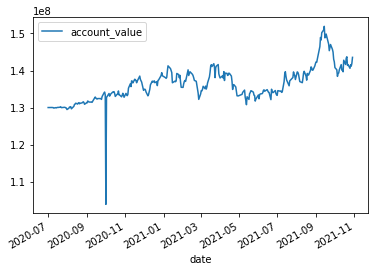

In [ ]:
df_date_ddpg.plot()

In [ ]:
df_date_ddpg.to_csv("ddpg_account_value.csv.gz")

In [ ]:
del df_account_value_ddpg_arr ; del df_actions_ddpg_arr

## PPO

In [ ]:
env_train.reset()
df_account_value_ppo_arr, df_actions_ppo_arr = [], []

for seed in tqdm(SEEDS, desc='All seeds', leave=True): # Looping from the given seeds

  # Train
  random.seed(seed); np.random.seed(seed) ; env_train.seed(seed)
  agent = DRLAgent(env = env_train)
  PPO_PARAMS = {
      "n_steps": 2048,
      "ent_coef": 0.01,
      "learning_rate": 0.00025,
      "batch_size": 128,
  }
  model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
  trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

  trained_ppo.save('trained_ppo.model') # save the model

  # Prediction
  df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)
  df_account_value_ppo.shape
  df_account_value_ppo.tail()
  df_actions_ppo.head()
  df_account_value_ppo_arr.append(df_account_value_ppo)
  df_actions_ppo_arr.append(df_actions_ppo)

All seeds:   0%|          | 0/3 [00:00<?, ?it/s]

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
----------------------------------
| time/              |           |
|    fps             | 266       |
|    iterations      | 1         |
|    time_elapsed    | 7         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 10.538477 |
----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 250          |
|    iterations           | 2            |
|    time_elapsed         | 16           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0074312477 |
|    clip_fraction        | 0.121        |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.8        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 |

# PPO for trading

In [ ]:
df_account_value_ppo_con = pd.concat((df_account_value_ppo_arr))
df_actions_ppo_con = pd.concat((df_actions_ppo_arr))

df_account_value_ppo_con_idx = df_account_value_ppo_con.groupby(df_account_value_ppo_con.index)
df_actions_ppo_con_idx = df_actions_ppo_con.groupby(df_actions_ppo_con.index)

df_account_value_means_ppo = df_account_value_ppo_con_idx.mean()
df_actions_means_ppo = df_actions_ppo_con_idx.mean()

In [ ]:
df_account_value_means_ppo['date'] = df_account_value_ppo_arr[0]['date']
df_account_value_means_ppo = df_account_value_means_ppo[['date', 'account_value']]
df_account_value_means_ppo.tail()

,date,account_value
312,2021-10-25,1.341304e+08
313,2021-10-26,1.345930e+08
314,2021-10-27,1.342190e+08
315,2021-10-28,1.347678e+08
316,2021-10-29,1.353768e+08


In [ ]:
df_actions_means_ppo

,1301,1332,1333,1376,1377,1379,1407,1414,1417
date,,,,,,,,,
2020-07-01,9.0,9.333333,2.333333,1.333333,4.0,5.0,6.0,12.666667,5.666667
2020-07-02,9.0,9.333333,2.333333,1.333333,4.0,5.0,6.0,12.666667,5.666667
2020-07-06,9.0,9.333333,2.333333,1.333333,4.0,5.0,6.0,12.666667,5.666667
2020-07-07,9.0,9.333333,2.333333,1.333333,4.0,5.0,6.0,12.666667,5.666667
2020-07-08,9.0,9.333333,2.333333,1.333333,4.0,5.0,6.0,12.666667,5.666667
...,...,...,...,...,...,...,...,...,...
2021-10-22,9.0,9.333333,2.333333,1.333333,4.0,5.0,6.0,12.666667,5.666667
2021-10-25,9.0,9.333333,2.333333,1.333333,4.0,5.0,6.0,12.666667,5.666667
2021-10-26,9.0,9.333333,2.333333,1.333333,4.0,5.0,6.0,12.666667,5.666667


## BackTestStats

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_ppo = backtest_stats(account_value=df_account_value_means_ppo)
perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.032742
Cumulative returns     0.041360
Annual volatility      0.053544
Sharpe ratio           0.630323
Calmar ratio           0.835184
Stability              0.361731
Max drawdown          -0.039204
Omega ratio            1.164912
Sortino ratio          0.938570
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.018914
Daily value at risk   -0.006612
dtype: float64


In [ ]:
df_date_ppo = df_account_value_means_ppo.set_index("date")

In [ ]:
df_date_ppo.index = pd.to_datetime(df_date_ppo.index)

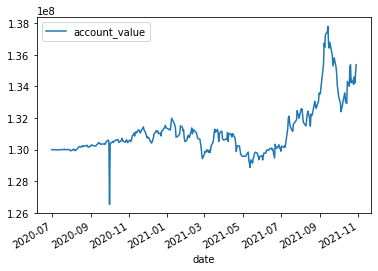

In [ ]:
df_date_ppo.plot()

In [ ]:
df_date_ppo.to_csv("PPO_account_value.csv.gz")

In [ ]:
del df_account_value_ppo_arr ; del df_actions_ppo_arr

## TD3

In [ ]:
env_train.reset()
df_account_value_td3_arr, df_actions_td3_arr = [], []

for seed in tqdm(SEEDS, desc='All seeds', leave=True): # Looping from the given seeds

  # Train
  random.seed(seed); np.random.seed(seed) ; env_train.seed(seed)

  agent = DRLAgent(env = env_train)
  TD3_PARAMS = {"batch_size": 100, 
                "buffer_size": 1000000, 
                "learning_rate": 0.001}

  model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)
  trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

  trained_td3.save('trained_td3.model') # save the model

  # Prediction
  df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym)
  df_account_value_td3.shape
  df_account_value_td3.tail()
  df_account_value_td3_arr.append(df_account_value_td3)
  df_actions_td3_arr.append(df_actions_td3)

All seeds:   0%|          | 0/3 [00:00<?, ?it/s]

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 100       |
|    time_elapsed    | 32        |
|    total_timesteps | 3296      |
| train/             |           |
|    actor_loss      | 2e+04     |
|    critic_loss     | 1.29e+07  |
|    learning_rate   | 0.001     |
|    n_updates       | 2472      |
|    reward          | 57.319347 |
----------------------------------
day: 823, episode: 570
begin_total_asset: 130000000.00
end_total_asset: 121691399.93
total_reward: -8308600.07
total_cost: 129870.13
total_trades: 4938
Sharpe: -0.034
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 88        |
|    time_elapsed    | 74        |
|    total_timesteps | 6592      |
| train/             |           |
|    actor_loss      | 2.32e+04  |
|    critic_

# TD3 for trading

In [ ]:
df_account_value_td3_con = pd.concat((df_account_value_td3_arr))
df_actions_td3_con = pd.concat((df_actions_td3_arr))

df_account_value_td3_con_idx = df_account_value_td3_con.groupby(df_account_value_td3_con.index)
df_actions_td3_con_idx = df_actions_td3_con.groupby(df_actions_td3_con.index)

df_account_value_means_td3 = df_account_value_td3_con_idx.mean()
df_actions_means_td3 = df_actions_td3_con_idx.mean()

In [ ]:
df_account_value_means_td3['date'] = df_account_value_td3_arr[0]['date']
df_account_value_means_td3 = df_account_value_means_td3[['date', 'account_value']]
df_account_value_means_td3.tail()

,date,account_value
312,2021-10-25,1.357942e+08
313,2021-10-26,1.364985e+08
314,2021-10-27,1.366720e+08
315,2021-10-28,1.369839e+08
316,2021-10-29,1.377747e+08


In [ ]:
df_actions_means_td3

,1301,1332,1333,1376,1377,1379,1407,1414,1417
date,,,,,,,,,
2020-07-01,100.0,66.666667,100.0,66.666667,100.0,66.666667,0.0,66.666667,66.666667
2020-07-02,100.0,66.666667,100.0,66.666667,100.0,66.666667,0.0,66.666667,66.666667
2020-07-06,100.0,66.666667,100.0,66.666667,100.0,66.666667,0.0,66.666667,66.666667
2020-07-07,100.0,66.666667,100.0,66.666667,100.0,66.666667,0.0,66.666667,66.666667
2020-07-08,100.0,66.666667,100.0,66.666667,100.0,66.666667,0.0,66.666667,66.666667
...,...,...,...,...,...,...,...,...,...
2021-10-22,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2021-10-25,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2021-10-26,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000


## BackTestStats

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_td3 = backtest_stats(account_value=df_account_value_means_td3)
perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.047258
Cumulative returns     0.059805
Annual volatility      0.424169
Sharpe ratio           0.312491
Calmar ratio           0.167826
Stability              0.365353
Max drawdown          -0.281588
Omega ratio            1.144162
Sortino ratio          0.516690
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.911668
Daily value at risk   -0.052914
dtype: float64


In [ ]:
df_date_td3 = df_account_value_means_td3.set_index("date")

In [ ]:
df_date_td3.index = pd.to_datetime(df_date_td3.index)

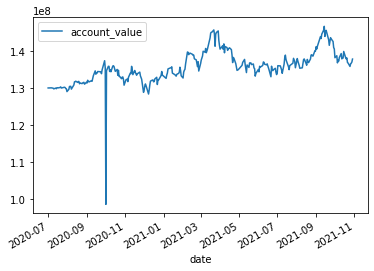

In [ ]:
df_date_td3.plot()

In [ ]:
df_date_td3.to_csv("TD3_account_value.csv.gz")

In [ ]:
del df_account_value_td3_arr ; del df_actions_td3_arr

## SAC

In [ ]:
env_train.reset()
df_account_value_sac_arr, df_actions_sac_arr = [], []

for seed in tqdm(SEEDS, desc='All seeds', leave=True): # Looping from the given seeds

  # Train
  random.seed(seed); np.random.seed(seed) ; env_train.seed(seed)
  agent = DRLAgent(env = env_train)
  SAC_PARAMS = {
      "batch_size": 128,
      "buffer_size": 1000000,
      "learning_rate": 0.0001,
      "learning_starts": 100,
      "ent_coef": "auto_0.1",
  }

  model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
  trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

  trained_sac.save('trained_sac.model') # save the model

  # Prediction
  df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)
  df_account_value_sac.shape
  df_account_value_sac.tail()
  df_actions_sac.head()
  df_account_value_sac_arr.append(df_account_value_sac)
  df_actions_sac_arr.append(df_actions_sac)

All seeds:   0%|          | 0/3 [00:00<?, ?it/s]

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
day: 823, episode: 680
begin_total_asset: 130000000.00
end_total_asset: 123611444.69
total_reward: -6388555.31
total_cost: 129870.13
total_trades: 3753
Sharpe: 0.138
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 51         |
|    time_elapsed    | 64         |
|    total_timesteps | 3296       |
| train/             |            |
|    actor_loss      | 2.13e+05   |
|    critic_loss     | 5.02e+06   |
|    ent_coef        | 0.135      |
|    ent_coef_loss   | 287        |
|    learning_rate   | 0.0001     |
|    n_updates       | 3195       |
|    reward          | -54.022785 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 50         |
|    time_elaps

# SAC for trading

In [ ]:
df_account_value_sac_con = pd.concat((df_account_value_sac_arr))
df_actions_sac_con = pd.concat((df_actions_sac_arr))

df_account_value_sac_con_idx = df_account_value_sac_con.groupby(df_account_value_sac_con.index)
df_actions_sac_con_idx = df_actions_sac_con.groupby(df_actions_sac_con.index)

df_account_value_means_sac = df_account_value_sac_con_idx.mean()
df_actions_means_sac = df_actions_sac_con_idx.mean()

In [ ]:
df_account_value_means_sac['date'] = df_account_value_sac_arr[0]['date']
df_account_value_means_sac = df_account_value_means_sac[['date', 'account_value']]
df_account_value_means_sac.tail()

,date,account_value
312,2021-10-25,1.437009e+08
313,2021-10-26,1.451156e+08
314,2021-10-27,1.445124e+08
315,2021-10-28,1.458852e+08
316,2021-10-29,1.469682e+08


In [ ]:
df_actions_means_sac

,1301,1332,1333,1376,1377,1379,1407,1414,1417
date,,,,,,,,,
2020-07-01,33.333333,66.666667,66.666667,33.333333,0.0,33.333333,33.333333,100.0,33.333333
2020-07-02,33.333333,66.666667,66.666667,33.333333,0.0,33.333333,33.333333,100.0,33.333333
2020-07-06,33.333333,66.666667,66.666667,33.333333,0.0,33.333333,33.333333,100.0,33.333333
2020-07-07,33.333333,66.666667,66.666667,33.333333,0.0,33.333333,33.333333,100.0,33.333333
2020-07-08,33.333333,66.666667,66.666667,33.333333,0.0,33.333333,33.333333,100.0,33.333333
...,...,...,...,...,...,...,...,...,...
2021-10-22,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2021-10-25,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2021-10-26,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


## BackTestStats

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_sac = backtest_stats(account_value=df_account_value_means_sac)
perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.102440
Cumulative returns     0.130525
Annual volatility      0.301843
Sharpe ratio           0.472800
Calmar ratio           0.508679
Stability              0.395904
Max drawdown          -0.201386
Omega ratio            1.163815
Sortino ratio          0.731495
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.936273
Daily value at risk   -0.037462
dtype: float64


In [ ]:
df_date_sac = df_account_value_means_sac.set_index("date")

In [ ]:
df_date_sac.index = pd.to_datetime(df_date_sac.index)

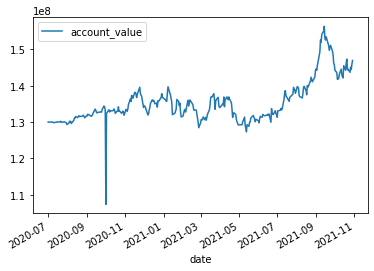

In [ ]:
df_date_sac.plot()

In [ ]:
df_date_sac.to_csv("SAC_account_value.csv.gz")

In [ ]:
del df_account_value_sac_arr ; del df_actions_sac_arr

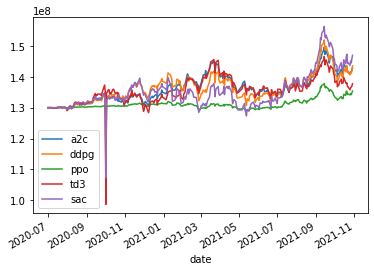

In [ ]:
df_date_a2c = df_date_a2c.rename(columns={'account_value': 'a2c'})
df_date_ddpg = df_date_ddpg.rename(columns={'account_value': 'ddpg'})
df_date_ppo = df_date_ppo.rename(columns={'account_value': 'ppo'})
df_date_td3 = df_date_td3.rename(columns={'account_value': 'td3'})
df_date_sac = df_date_sac.rename(columns={'account_value': 'sac'})

ax = df_date_a2c.plot()
df_date_ddpg.plot(ax=ax)
df_date_ppo.plot(ax=ax)
df_date_td3.plot(ax=ax)
df_date_sac.plot(ax=ax)

In [ ]:
!cp a2c_account_value.csv.gz "/content/drive/My Drive"
!cp ddpg_account_value.csv.gz "/content/drive/My Drive"
!cp PPO_account_value.csv.gz "/content/drive/My Drive"
!cp TD3_account_value.csv.gz "/content/drive/My Drive"
!cp SAC_account_value.csv.gz "/content/drive/My Drive"
!cp trained_a2c.model "/content/drive/My Drive"
!cp trained_ddpg.model "/content/drive/My Drive"
!cp trained_ppo.model "/content/drive/My Drive"
!cp trained_td3.model "/content/drive/My Drive"
!cp trained_sac.model "/content/drive/My Drive"

cp: cannot stat 'SAC_account_value.csv.gz': No such file or directory
